In [1]:
%matplotlib inline

import os
from shutil import copyfile, move
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .getOrCreate()




In [3]:
transformed_table = spark.read.load("/project/ds5559/BioNerds/saved_data/clean_indexed.parquet")

In [4]:
ResNet50_Folder = "/project/ds5559/BioNerds/saved_data/ResNet50_testing/"

In [5]:
training_flder = ResNet50_Folder + "training/"
test_flder = ResNet50_Folder + "test/"
checkpoint_path = "checkpoint_model/cp.ckpt"
checkpoint_dir = os.path.join(ResNet50_Folder,checkpoint_path)

# split transformed_table to training set and test set by dx value.
# using stratified split by ratio 0.8:0.2

In [6]:
dx_table = transformed_table.select("dx", "indexed_dx").groupby("dx","indexed_dx").count()
dx_table.show()

+-----+----------+-----+
|   dx|indexed_dx|count|
+-----+----------+-----+
|  bcc|       3.0|  514|
|  mel|       1.0| 1111|
|   nv|       0.0| 6650|
|  bkl|       2.0| 1089|
|   df|       6.0|  115|
| vasc|       5.0|  142|
|akiec|       4.0|  327|
+-----+----------+-----+



In [7]:
fractions = transformed_table.select("dx").distinct().withColumn("fraction", F.lit(0.8)).rdd.collectAsMap()
fractions

{'vasc': 0.8,
 'nv': 0.8,
 'mel': 0.8,
 'bcc': 0.8,
 'df': 0.8,
 'bkl': 0.8,
 'akiec': 0.8}

In [8]:
training_set = transformed_table.stat.sampleBy("dx",fractions, seed=314)
training_set.cache()
test_set = transformed_table.subtract(training_set)
test_set.cache()

DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string, features_2: vector, pcaFeatures: vector, indexed_dx: double, indexed_sex: double, indexed_loc: double, Feature_vec: vector]

In [9]:
training_set.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0027564|HAM_0004826|ISIC_0027564| nv|follow_up|45.0|  male|        genital|[0.0,0.0,0.0,0.0,...|[-67.127555823468...|       0.0|        0.0|       13.0|[-67.127555823468...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0025753|HAM_0004912|ISIC_0025753|bkl| confocal|70.0|  male|     

In [10]:
test_set.show(5)

+--------------------+--------------------+------------+-----------+------------+-----+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id|   dx|  dx_type| age|   sex|   localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+-----+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0029039|HAM_0004317|ISIC_0029039|   df|    histo|50.0|female|lower extremity|[0.0,0.0,0.0,0.0,...|[82.5500326269682...|       6.0|        1.0|        1.0|[82.5500326269682...|
|file:/project/ds5...|[0.0, 0.0, 0.0848...|ISIC_0025584|HAM_0000791|ISIC_0025584|  bcc|    histo|80.0|  

# create training and test folders

#### make training folder

In [ ]:
os.mkdir(training_flder)
os.mkdir(test_flder)

In [51]:
for row in dx_table.rdd.collect():
    training_folder = training_flder + row[0] + "_" + str(int(row[1]))
    #print(training_folder)
    os.mkdir(training_folder)

In [42]:
training_info = training_set.rdd.map(lambda x: (x.image_id, x.dx, x.indexed_dx , x.path)).collect()

In [61]:
for f in enumerate(training_info):
    org = f[1][3][5:]
    dest = training_flder+f[1][1]+"_"+str(int(f[1][2]))

    copyfile(os.path.join(org), os.path.join(dest, f[1][0]+".jpg" ))


#### make test folders

In [62]:
for row in dx_table.rdd.collect():
    test_folder = test_flder + row[0] + "_" + str(int(row[1]))
    os.mkdir(test_folder)

In [12]:
test_info = test_set.rdd.map(lambda x: (x.image_id, x.dx, x.indexed_dx , x.path)).collect()

In [13]:
for f in enumerate(test_info):
    org = f[1][3][5:]
    dest = test_flder+f[1][1]+"_"+str(int(f[1][2]))

    copyfile(os.path.join(org), os.path.join(dest, f[1][0]+".jpg"))


# prepare training and test datasets

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(training_flder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7978 files belonging to 7 classes.


In [9]:
class_names = train_dataset.class_names
print(class_names)

['akiec_4', 'bcc_3', 'bkl_2', 'df_6', 'mel_1', 'nv_0', 'vasc_5']


In [10]:
#train_dataset.class_names_index

In [11]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
validation_dataset = image_dataset_from_directory(test_flder,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1970 files belonging to 7 classes.


# show the first nine images and labels from the training set

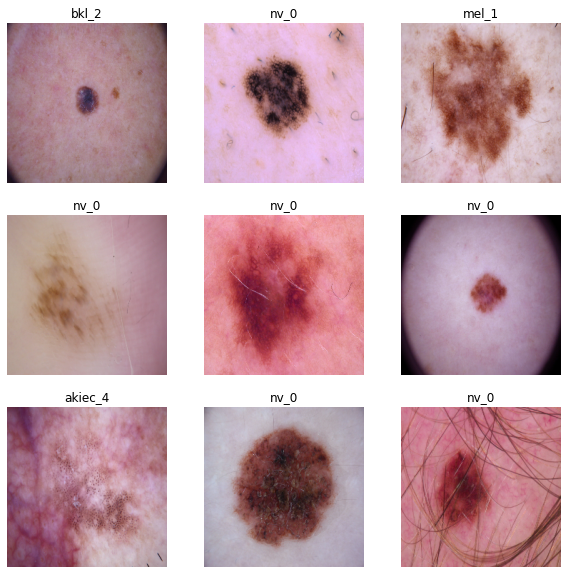

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### move 20% of them to as test set

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 50
Number of test batches: 12


### configure the dataset for performace

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### use data augmentation, rotating images

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

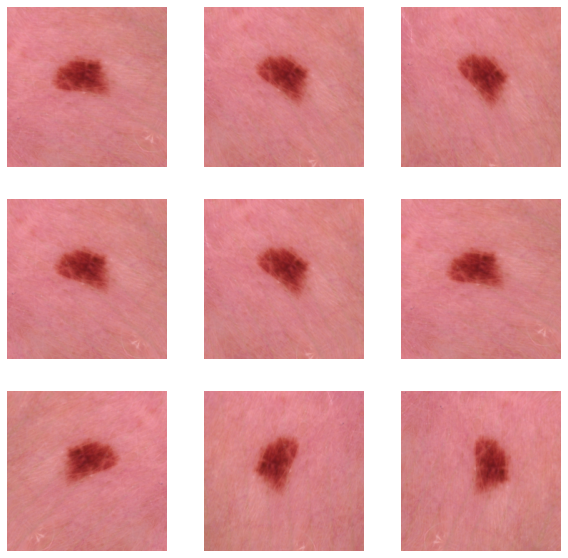

In [19]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Load Keras pre-trained ResNet50 as a base model

In [19]:
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),include_top=False, weights='imagenet')

In [20]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [25]:
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


## Create a new model from ResNet50 base model

In [26]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(7)(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### only the top layer is trainable

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
____________________________________________

#### accuracy of the model without training

In [29]:
initial_epochs = 10

In [30]:
loss0, accuracy0 = model.evaluate(validation_dataset)

50/50 [==============================] - 73s 1s/step - loss: 2.0295 - accuracy: 0.2043


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.03
initial accuracy: 0.20


In [ ]:
checkpoint_path = "checkpoint_model/cp.ckpt"
checkpoint_dir = os.path.join(ResNet50_Folder,checkpoint_path)

#os.mkdir(checkpoint_dir)

In [27]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### traing the top layer of the new model in first 10 epochs 

In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback])

Epoch 1/10
250/250 [==============================] - 434s 2s/step - loss: 1.0142 - accuracy: 0.6647 - val_loss: 0.7685 - val_accuracy: 0.7232

Epoch 00001: saving model to checkpoint_model/cp.ckpt
Epoch 2/10
250/250 [==============================] - 429s 2s/step - loss: 0.8209 - accuracy: 0.7118 - val_loss: 0.6910 - val_accuracy: 0.7528

Epoch 00002: saving model to checkpoint_model/cp.ckpt
Epoch 3/10
250/250 [==============================] - 428s 2s/step - loss: 0.7693 - accuracy: 0.7215 - val_loss: 0.6720 - val_accuracy: 0.7554

Epoch 00003: saving model to checkpoint_model/cp.ckpt
Epoch 4/10
250/250 [==============================] - 428s 2s/step - loss: 0.7407 - accuracy: 0.7320 - val_loss: 0.6594 - val_accuracy: 0.7629

Epoch 00004: saving model to checkpoint_model/cp.ckpt
Epoch 5/10
250/250 [==============================] - 428s 2s/step - loss: 0.7338 - accuracy: 0.7364 - val_loss: 0.6859 - val_accuracy: 0.7421

Epoch 00005: saving model to checkpoint_model/cp.ckpt
Epoch 6/10

### save the model, and training values

In [31]:
model_path = "model"
model_dir = os.path.join(ResNet50_Folder,model_path)
model.save(model_dir)

/home/jh4yd/.local/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /project/ds5559/BioNerds/saved_data/ResNet50_testing/model/assets


In [ ]:
history_df = pd.DataFrame({'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss})
history_df.to_csv("history_table.csv")

# learning curves

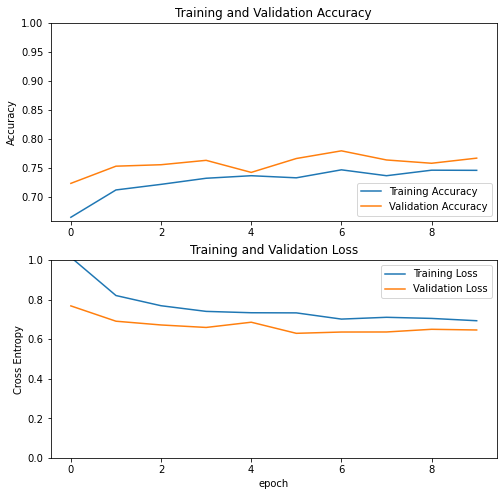

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### load model and training  values

In [23]:
model_dir = "/project/ds5559/BioNerds/saved_data/ResNet50_testing/model_epoch30"
model = tf.keras.models.load_model(model_dir)
history_csv = pd.read_csv("history_table.csv")
acc = history_csv['acc'].tolist()
val_acc = history_csv['val_acc'].tolist()
loss = history_csv['loss'].tolist()
val_loss = history_csv['val_loss'].tolist()


# fine tune (base model: from  layer 150 --> 175)

In [25]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [27]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/2),
              #loss='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 10,004,487
Non-trainable params: 13,597,568
________________________________________

In [30]:
len(model.trainable_variables)

32

#### training(epoch 10-50)

In [31]:
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 31/50
250/250 [==============================] - 560s 2s/step - loss: 0.3179 - accuracy: 0.8881 - val_loss: 0.5462 - val_accuracy: 0.8298
Epoch 32/50
250/250 [==============================] - 554s 2s/step - loss: 0.3108 - accuracy: 0.8868 - val_loss: 0.5091 - val_accuracy: 0.8367
Epoch 33/50
250/250 [==============================] - 554s 2s/step - loss: 0.2934 - accuracy: 0.8940 - val_loss: 0.5294 - val_accuracy: 0.8291
Epoch 34/50
250/250 [==============================] - 555s 2s/step - loss: 0.2741 - accuracy: 0.9027 - val_loss: 0.5474 - val_accuracy: 0.8209
Epoch 35/50
250/250 [==============================] - 555s 2s/step - loss: 0.2610 - accuracy: 0.9032 - val_loss: 0.5555 - val_accuracy: 0.8203
Epoch 36/50
250/250 [==============================] - 860s 3s/step - loss: 0.2584 - accuracy: 0.9093 - val_loss: 0.5461 - val_accuracy: 0.8172
Epoch 37/50
250/250 [==============================] - 744s 3s/step - loss: 0.2566 - accuracy: 0.9037 - val_loss: 0.5835 - val_accuracy:

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

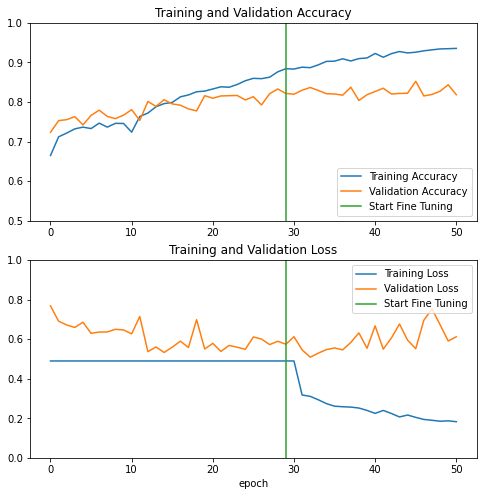

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save the Final Model and traing, validating values

In [ ]:
model_path = "Final_model"
model_dir = os.path.join(ResNet50_Folder,model_path)
model.save(model_dir)

In [ ]:
history_df = pd.DataFrame({'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss})
history_df.to_csv("history_table.csv")

# Test the model with test set

In [34]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test accuracy :', test_accuracy)

12/12 [==============================] - 17s 1s/step - loss: 0.6951 - accuracy: 0.8203
Test accuracy : 0.8203125


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

In [38]:
label = np.concatenate([y for x, y in test_dataset], axis=0)

In [39]:
predictions = model.predict(test_dataset)
y_pred= np.argmax(predictions, axis=1)

In [40]:
cm= confusion_matrix(label,y_pred)
print(cm)

[[  0   0   3   0   1   7   0]
 [  0   1   1   0   6  14   0]
 [  3   4   3   0   4  33   0]
 [  0   0   1   0   1   4   0]
 [  2   2   7   0   4  33   0]
 [ 12  17  19   1  30 168   1]
 [  0   1   0   0   1   0   0]]


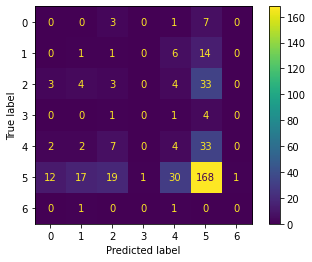

In [41]:
ConfusionMatrixDisplay(cm).plot()